In [1]:
import time
import random
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [7]:
#import gym bipedal walker
env = gym.make("BipedalWalker-v3")

## Model structure
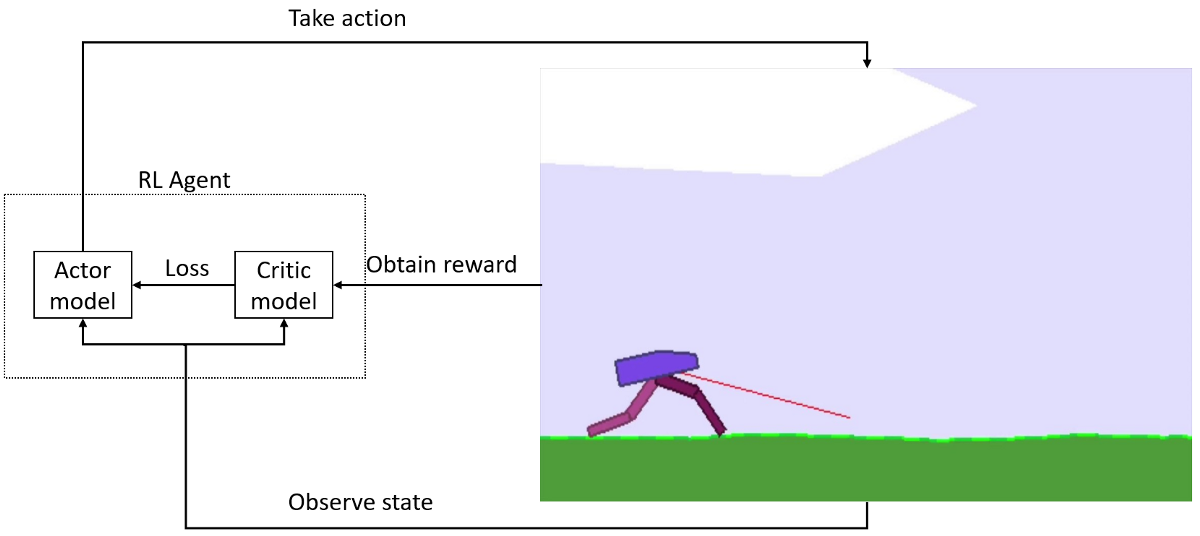

### NickKaparinos approach
https://github.com/NickKaparinos/OpenAI-Gym-Projects/tree/master/Box2D/BipedalWalker

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from stable_baselines3.common.callbacks import BaseCallback
from tqdm import tqdm
from os import listdir
from tensorflow.python.summary.summary_iterator import summary_iterator


In [3]:
# utilities.py

class LogStepsCallback(BaseCallback):
    def __init__(self, log_dir, verbose=0):
        self.log_dir = log_dir
        super(LogStepsCallback, self).__init__(verbose)

    def _on_training_start(self) -> None:
        self.results = pd.DataFrame(columns=['Reward', 'Done'])
        print("Τraining starts!")

    def _on_step(self) -> bool:
        if 'reward' in self.locals:
            keys = ['reward', 'done']
        else:
            keys = ['rewards', 'dones']
        self.results.loc[len(self.results)] = [self.locals[keys[0]][0], self.locals[keys[1]][0]]
        return True

    def _on_training_end(self) -> None:
        self.results.to_csv(self.log_dir + 'training_data.csv', index=False)
        print("Τraining ends!")


class TqdmCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.progress_bar = None

    def _on_training_start(self):
        self.progress_bar = tqdm(total=self.locals['total_timesteps'])

    def _on_step(self):
        self.progress_bar.update(1)
        return True

    def _on_training_end(self):
        self.progress_bar.close()
        self.progress_bar = None


def save_dict_to_file(dict, path, txt_name='hyperparameter_dict'):
    f = open(path + '/' + txt_name + '.txt', 'w')
    f.write(str(dict))
    f.close()


def calc_episode_rewards(training_data):
    # Calculate the rewards for each training episode
    episode_rewards = []
    temp_reward_sum = 0

    for step in range(training_data.shape[0]):
        reward, done = training_data.iloc[step, :]
        temp_reward_sum += reward
        if done:
            episode_rewards.append(temp_reward_sum)
            temp_reward_sum = 0

    result = pd.DataFrame(columns=['Reward'])
    result['Reward'] = episode_rewards
    return result


def learning_curve(episode_rewards, log_dir, window=10):
    # Calculate rolling window metrics
    rolling_average = episode_rewards.rolling(window=window, min_periods=window).mean().dropna()
    rolling_max = episode_rewards.rolling(window=window, min_periods=window).max().dropna()
    rolling_min = episode_rewards.rolling(window=window, min_periods=window).min().dropna()

    # Change column name
    rolling_average.columns = ['Average Reward']
    rolling_max.columns = ['Max Reward']
    rolling_min.columns = ['Min Reward']
    rolling_data = pd.concat([rolling_average, rolling_max, rolling_min], axis=1)

    # Plot
    sns.set()
    ax = sns.lineplot(data=rolling_data)
    ax.fill_between(rolling_average.index, rolling_min.iloc[:, 0], rolling_max.iloc[:, 0], alpha=0.2)
    ax.set_title('Learning Curve')
    ax.set_ylabel('Reward')
    ax.set_xlabel('Episodes')

    # Save figure
    plt.savefig(log_dir + 'learning_curve' + str(window) + '.png')


def learning_curve_baselines(log_dir, window=10):
    # Read data
    training_data = pd.read_csv(log_dir + 'training_data.csv', index_col=None)

    # Calculate episode rewards
    episode_rewards = calc_episode_rewards(training_data)

    learning_curve(episode_rewards=episode_rewards, log_dir=log_dir, window=window)


def learning_curve_tianshou(log_dir, window=10):
    # Find event file
    files = listdir(log_dir)
    for f in files:
        if 'events' in f:
            event_file = f
            break

    # Read episode rewards
    episode_rewards_list = []
    episode_rewards = pd.DataFrame(columns=['Reward'])
    try:
        for e in summary_iterator(log_dir + event_file):
            if len(e.summary.value) > 0:
                if e.summary.value[0].tag == 'train/reward':
                    episode_rewards_list.append(e.summary.value[0].simple_value)
    except Exception as e:
        pass
    episode_rewards['Reward'] = episode_rewards_list

    # Learning curve
    learning_curve(episode_rewards, log_dir, window=window)


def learning_curve_tianshou_multiple_runs(log_dirs, window=10):
    episode_rewards_list = []
    episode_rewards = pd.DataFrame(columns=['Reward'])

    for log_dir in log_dirs:
        # Find event file
        files = listdir(log_dir)
        for f in files:
            if 'events' in f:
                event_file = f
                break

        # Read episode rewards
        try:
            for e in summary_iterator(log_dir + event_file):
                if len(e.summary.value) > 0:
                    if e.summary.value[0].tag == 'train/reward':
                        episode_rewards_list.append(e.summary.value[0].simple_value)
        except Exception as e:
            pass
    episode_rewards['Reward'] = episode_rewards_list

    # Learning curve
    learning_curve(episode_rewards, log_dir, window=window)

In [4]:

import time

from gym import wrappers
import gym
import tianshou as ts
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger
from tianshou.exploration import GaussianNoise, OUNoise
from tianshou.policy import SACPolicy
import torch
from tianshou.utils.net.common import Net
from tianshou.utils.net.continuous import Critic, ActorProb


In [5]:

start = time.perf_counter()
env_id = "BipedalWalker-v3"
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_pretrained_model = False
model_path = ''

In [6]:
# Logging directory
model_name = 'Tianshou_SAC'
log_dir = 'logs/' + model_name + '_' + str(time.strftime('%d_%b_%Y_%H_%M_%S', time.localtime())) + '/'
writer = SummaryWriter(log_dir=log_dir)
logger = TensorboardLogger(writer, train_interval=1, update_interval=1)


In [7]:
# Environment
env = gym.make(env_id)
env.seed(seed=seed)

train_envs = ts.env.DummyVectorEnv([lambda: gym.make(env_id) for _ in range(1)])

test_envs = ts.env.DummyVectorEnv(
    [lambda: gym.make(env_id) for _ in range(1)])
train_envs.seed(seed)
test_envs.seed(seed)


[[0]]

In [8]:
# Neural networks and policy
state_shape = env.observation_space.shape or env.observation_space.n
action_shape = env.action_space.shape or env.action_space.n
max_action = env.action_space.high[0]
model_hyperparameters = {'hidden_sizes': [256, 256], 'learning_rate': 1e-3, 'estimation_step': 4}


In [9]:

# Actor
net_a = Net(state_shape, hidden_sizes=model_hyperparameters['hidden_sizes'], device=device)
actor = ActorProb(net_a, action_shape, max_action=max_action, device=device, unbounded=True).to(device)
actor_optim = torch.optim.Adam(actor.parameters(), lr=model_hyperparameters['learning_rate'])


In [10]:
# Critics
net_c1 = Net(state_shape, action_shape, hidden_sizes=model_hyperparameters['hidden_sizes'], concat=True,
                device=device)
critic1 = Critic(net_c1, device=device).to(device)
critic1_optim = torch.optim.Adam(critic1.parameters(), lr=model_hyperparameters['learning_rate'])
net_c2 = Net(state_shape, action_shape, hidden_sizes=model_hyperparameters['hidden_sizes'], concat=True,
                device=device)
critic2 = Critic(net_c2, device=device).to(device)
critic2_optim = torch.optim.Adam(critic2.parameters(), lr=model_hyperparameters['learning_rate'])


In [11]:
# Alpha
target_entropy = -np.prod(env.action_space.shape)
log_alpha = torch.zeros(1, requires_grad=True, device=device)
alpha_lr = 1e-5
alpha_optim = torch.optim.Adam([log_alpha], lr=alpha_lr)
alpha = (target_entropy, log_alpha, alpha_optim)

policy = SACPolicy(actor, actor_optim, critic1, critic1_optim, critic2, critic2_optim,
                    exploration_noise=GaussianNoise(sigma=2 * max_action),
                    estimation_step=model_hyperparameters['estimation_step'],
                    action_space=env.action_space, alpha=alpha)


In [12]:
# Collectors
use_prioritised_replay_buffer = False
prioritized_buffer_hyperparameters = {'total_size': 1_000_000, 'buffer_num': 1, 'alpha': 0.4, 'beta': 0.5}
if use_prioritised_replay_buffer:
    train_collector = ts.data.Collector(policy, train_envs,
                                        ts.data.PrioritizedVectorReplayBuffer(**prioritized_buffer_hyperparameters),
                                        exploration_noise=True)
else:
    train_collector = ts.data.Collector(policy, train_envs,
                                        ts.data.ReplayBuffer(size=prioritized_buffer_hyperparameters['total_size']),
                                        exploration_noise=True)
test_collector = ts.data.Collector(policy, test_envs, exploration_noise=True)


In [13]:
# Sigma schedule
def build_sigma_schedule(max_sigma=0.5, min_sigma=0.0, steps_per_epoch=50_000, decay_time_steps=10_000):
    def custom_sigma_schedule(epoch, env_step):
        decay_per_step = (max_sigma - min_sigma) / decay_time_steps
        step_number = (epoch - 1) * steps_per_epoch + env_step

        current_sigma = max_sigma - step_number * decay_per_step
        if current_sigma < 0.0:
            current_sigma = 0.0
        policy._noise = GaussianNoise(sigma=current_sigma * max_action)

    return custom_sigma_schedule


In [14]:
# Test function
def build_test_fn(num_episodes):
    def custom_test_fn(epoch, env_step):
        print(f"Epoch = {epoch}")

        # Save agent
        torch.save(policy.state_dict(), log_dir + model_name + f'_epoch{epoch}.pth')

        # Record agents performance in video
        for episode in range(num_episodes):
            env = ts.env.DummyVectorEnv(
                [lambda: wrappers.Monitor(env=gym.make(env_id), directory=log_dir + '/videos/epoch_' + str(
                    epoch) + '/video' + str(episode), force=False) for _ in range(1)])

            # Video
            policy.eval()
            collector = ts.data.Collector(policy, env, exploration_noise=True)
            collector.collect(n_episode=1, render=1 / 60)

    return custom_test_fn



In [15]:
# Training
trainer_hyperparameters = {'max_epoch': 6, 'step_per_epoch': 200_000, 'step_per_collect': 10,
                            'episode_per_test': 10,
                            'batch_size': 128}
decay_steps = int(trainer_hyperparameters['max_epoch'] * trainer_hyperparameters['step_per_epoch'] * 0.05)
build_sigma_hyperparameters = {'max_sigma': 0.6, 'min_sigma': 0.0, 'decay_time_steps': decay_steps}
all_hypeparameters = dict(model_hyperparameters, **trainer_hyperparameters, **prioritized_buffer_hyperparameters)
all_hypeparameters['seed'] = seed
all_hypeparameters['use_prioritised_replay_buffer'] = use_prioritised_replay_buffer
all_hypeparameters['alpha_lr'] = alpha_lr
if load_pretrained_model:
    policy.load_state_dict(torch.load(model_path))
    all_hypeparameters['load_pretrained_model'] = load_pretrained_model
    all_hypeparameters['model_path'] = model_path
save_dict_to_file(all_hypeparameters, path=log_dir)

result = ts.trainer.offpolicy_trainer(policy, train_collector, test_collector, **trainer_hyperparameters,
                                        train_fn=build_sigma_schedule(**build_sigma_hyperparameters,
                                                                    steps_per_epoch=trainer_hyperparameters[
                                                                        'step_per_epoch']),
                                        test_fn=build_test_fn(num_episodes=5), stop_fn=None, logger=logger)
print(f'Finished training! Use {result["duration"]}')


Epoch = 0


/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitor.py:29: DeprecationWarning: WARN: The Monitor wrapper is being deprecated in favor of gym.wrappers.RecordVideo and gym.wrappers.RecordEpisodeStatistics (see https://github.com/openai/gym/issues/2297)
  logger.deprecation(
2023-05-11 13:48:36.776 Python[57285:1191487] ApplePersistenceIgnoreState: Existing state will not be touched. New state will be written to /var/folders/18/27kk04gn68z8t3bc0npl90x00000gn/T/org.python.python.savedState
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version classes are deprecated. Use packaging.ver

Epoch = 1


/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitor.py:29: DeprecationWarning: WARN: The Monitor wrapper is being deprecated in favor of gym.wrappers.RecordVideo and gym.wrappers.RecordEpisodeStatistics (see https://github.com/openai/gym/issues/2297)
  logger.deprecation(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version cla

Epoch #1: test_reward: -4.151042 ± 0.066378, best_reward: -4.151042 ± 0.066378 in #1


Epoch #2: 200001it [19:29, 171.04it/s, alpha=0.018, env_step=400000, len=1600, loss/actor=2.096, loss/alpha=-18.346, loss/critic1=0.088, loss/critic2=0.086, n/ep=0, n/st=10, rew=28.54]                              
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitor.py:29: DeprecationWarning: WARN: The Monitor wrapper is being deprecated in favor of gym.wrappers.RecordVideo and gym.wrappers.RecordEpisodeStatistics (see https://github.com/openai/gym/issues/2297)
  logger.deprecation(


Epoch = 2


/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitor.py:29: DeprecationWarning: WARN: The Monitor wrapper is being deprecated in favor of gym.wrappers.RecordVideo and gym.wrappers.RecordEpisodeStatistics (see https://github.com/openai/gym/issues/2297)
  logger.deprecation(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version cla

Epoch #2: test_reward: -62.171935 ± 3.753587, best_reward: -4.151042 ± 0.066378 in #1


Epoch #3: 200001it [19:30, 170.82it/s, alpha=0.012, env_step=600000, len=949, loss/actor=-10.041, loss/alpha=1.536, loss/critic1=0.684, loss/critic2=0.673, n/ep=0, n/st=10, rew=283.47]                             
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitor.py:29: DeprecationWarning: WARN: The Monitor wrapper is being deprecated in favor of gym.wrappers.RecordVideo and gym.wrappers.RecordEpisodeStatistics (see https://github.com/openai/gym/issues/2297)
  logger.deprecation(


Epoch = 3


/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitor.py:29: DeprecationWarning: WARN: The Monitor wrapper is being deprecated in favor of gym.wrappers.RecordVideo and gym.wrappers.RecordEpisodeStatistics (see https://github.com/openai/gym/issues/2297)
  logger.deprecation(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version cla

Epoch #3: test_reward: 286.930099 ± 1.246647, best_reward: 286.930099 ± 1.246647 in #3


Epoch #4: 200001it [19:36, 170.01it/s, alpha=0.013, env_step=800000, len=843, loss/actor=-15.378, loss/alpha=0.778, loss/critic1=1.312, loss/critic2=1.292, n/ep=0, n/st=10, rew=292.22]                             
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitor.py:29: DeprecationWarning: WARN: The Monitor wrapper is being deprecated in favor of gym.wrappers.RecordVideo and gym.wrappers.RecordEpisodeStatistics (see https://github.com/openai/gym/issues/2297)
  logger.deprecation(


Epoch = 4


/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitor.py:29: DeprecationWarning: WARN: The Monitor wrapper is being deprecated in favor of gym.wrappers.RecordVideo and gym.wrappers.RecordEpisodeStatistics (see https://github.com/openai/gym/issues/2297)
  logger.deprecation(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version cla

Epoch #4: test_reward: 294.246048 ± 0.572889, best_reward: 294.246048 ± 0.572889 in #4


Epoch #5: 200001it [19:40, 169.37it/s, alpha=0.014, env_step=1000000, len=811, loss/actor=-18.627, loss/alpha=-0.206, loss/critic1=3.231, loss/critic2=3.312, n/ep=0, n/st=10, rew=296.70]                            
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitor.py:29: DeprecationWarning: WARN: The Monitor wrapper is being deprecated in favor of gym.wrappers.RecordVideo and gym.wrappers.RecordEpisodeStatistics (see https://github.com/openai/gym/issues/2297)
  logger.deprecation(


Epoch = 5


/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitor.py:29: DeprecationWarning: WARN: The Monitor wrapper is being deprecated in favor of gym.wrappers.RecordVideo and gym.wrappers.RecordEpisodeStatistics (see https://github.com/openai/gym/issues/2297)
  logger.deprecation(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version cla

Epoch #5: test_reward: 302.835263 ± 1.760031, best_reward: 302.835263 ± 1.760031 in #5
Finished training! Use 7190.24s


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitor.py:29: DeprecationWarning: WARN: The Monitor wrapper is being deprecated in favor of gym.wrappers.RecordVideo and gym.wrappers.RecordEpisodeStatistics (see https://github.com/openai/gym/issues/2297)
  logger.deprecation(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(
/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitor.py:29: DeprecationWarning: WARN: The Monitor wrapper is being depre


Execution time = 7960.60 second(s)


/Users/michaelfuglo/Projects/BipedalWalker2D/.venv/lib/python3.9/site-packages/gym/wrappers/monitoring/video_recorder.py:413: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(


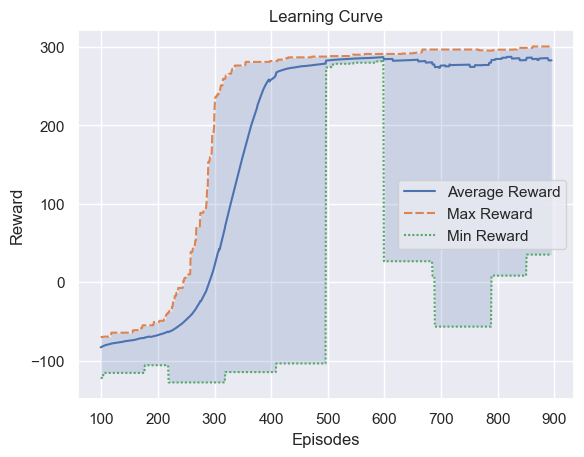

In [16]:
# Learning Curve
learning_curve_tianshou(log_dir=log_dir, window=100)

# Record Episode Video
num_episodes = 10
for i in range(num_episodes):
    env = ts.env.DummyVectorEnv(
        [lambda: wrappers.Monitor(env=gym.make(env_id), directory=log_dir + '/videos/final_agent/video' + str(i),
                                    force=False) for _ in range(1)])

    # Video
    policy.eval()
    collector = ts.data.Collector(policy, env, exploration_noise=False)
    collector.collect(n_episode=1, render=1 / 60)

# Save policy
torch.save(policy.state_dict(), log_dir + model_name + '.pth')

# Execution Time
end = time.perf_counter()  # tensorboard --logdir './Box2D/BipedalWalker/logs'
print(f"\nExecution time = {end - start:.2f} second(s)")

In [19]:
# main.py

start = time.perf_counter()
env_id = "BipedalWalker-v3"
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_pretrained_model = False
model_path = ''

# Logging directory
model_name = 'Tianshou_SAC'
log_dir = 'logs/' + model_name + '_' + str(time.strftime('%d_%b_%Y_%H_%M_%S', time.localtime())) + '/'
writer = SummaryWriter(log_dir=log_dir)
logger = TensorboardLogger(writer, train_interval=1, update_interval=1)

# Environment
env = gym.make(env_id)
env.seed(seed=seed)

train_envs = ts.env.DummyVectorEnv(
    [lambda: gym.make(env_id) for _ in range(1)])
test_envs = ts.env.DummyVectorEnv(
    [lambda: gym.make(env_id) for _ in range(1)])
train_envs.seed(seed)
test_envs.seed(seed)

# Neural networks and policy
state_shape = env.observation_space.shape or env.observation_space.n
action_shape = env.action_space.shape or env.action_space.n
max_action = env.action_space.high[0]
model_hyperparameters = {'hidden_sizes': [256, 256], 'learning_rate': 1e-3, 'estimation_step': 4}

# Actor
net_a = Net(state_shape, hidden_sizes=model_hyperparameters['hidden_sizes'], device=device)
actor = ActorProb(net_a, action_shape, max_action=max_action, device=device, unbounded=True).to(device)
actor_optim = torch.optim.Adam(actor.parameters(), lr=model_hyperparameters['learning_rate'])

# Critics
net_c1 = Net(state_shape, action_shape, hidden_sizes=model_hyperparameters['hidden_sizes'], concat=True,
                device=device)
critic1 = Critic(net_c1, device=device).to(device)
critic1_optim = torch.optim.Adam(critic1.parameters(), lr=model_hyperparameters['learning_rate'])
net_c2 = Net(state_shape, action_shape, hidden_sizes=model_hyperparameters['hidden_sizes'], concat=True,
                device=device)
critic2 = Critic(net_c2, device=device).to(device)
critic2_optim = torch.optim.Adam(critic2.parameters(), lr=model_hyperparameters['learning_rate'])

# Alpha
target_entropy = -np.prod(env.action_space.shape)
log_alpha = torch.zeros(1, requires_grad=True, device=device)
alpha_lr = 1e-5
alpha_optim = torch.optim.Adam([log_alpha], lr=alpha_lr)
alpha = (target_entropy, log_alpha, alpha_optim)

policy = SACPolicy(actor, actor_optim, critic1, critic1_optim, critic2, critic2_optim,
                    exploration_noise=GaussianNoise(sigma=2 * max_action),
                    estimation_step=model_hyperparameters['estimation_step'],
                    action_space=env.action_space, alpha=alpha)

# Collectors
use_prioritised_replay_buffer = False
prioritized_buffer_hyperparameters = {'total_size': 1_000_000, 'buffer_num': 1, 'alpha': 0.4, 'beta': 0.5}
if use_prioritised_replay_buffer:
    train_collector = ts.data.Collector(policy, train_envs,
                                        ts.data.PrioritizedVectorReplayBuffer(**prioritized_buffer_hyperparameters),
                                        exploration_noise=True)
else:
    train_collector = ts.data.Collector(policy, train_envs,
                                        ts.data.ReplayBuffer(size=prioritized_buffer_hyperparameters['total_size']),
                                        exploration_noise=True)
test_collector = ts.data.Collector(policy, test_envs, exploration_noise=True)

# Sigma schedule
def build_sigma_schedule(max_sigma=0.5, min_sigma=0.0, steps_per_epoch=50_000, decay_time_steps=10_000):
    def custom_sigma_schedule(epoch, env_step):
        decay_per_step = (max_sigma - min_sigma) / decay_time_steps
        step_number = (epoch - 1) * steps_per_epoch + env_step

        current_sigma = max_sigma - step_number * decay_per_step
        if current_sigma < 0.0:
            current_sigma = 0.0
        policy._noise = GaussianNoise(sigma=current_sigma * max_action)

    return custom_sigma_schedule

# Test function
def build_test_fn(num_episodes):
    def custom_test_fn(epoch, env_step):
        print(f"Epoch = {epoch}")

        # Save agent
        torch.save(policy.state_dict(), log_dir + model_name + f'_epoch{epoch}.pth')

        # Record agents performance in video
        for episode in range(num_episodes):
            env = ts.env.DummyVectorEnv(
                [lambda: wrappers.Monitor(env=gym.make(env_id), directory=log_dir + '/videos/epoch_' + str(
                    epoch) + '/video' + str(episode), force=False) for _ in range(1)])

            # Video
            policy.eval()
            collector = ts.data.Collector(policy, env, exploration_noise=True)
            collector.collect(n_episode=1, render=1 / 60)

    return custom_test_fn


# Training
trainer_hyperparameters = {'max_epoch': 6, 'step_per_epoch': 200_000, 'step_per_collect': 10,
                            'episode_per_test': 10,
                            'batch_size': 128}
decay_steps = int(trainer_hyperparameters['max_epoch'] * trainer_hyperparameters['step_per_epoch'] * 0.05)
build_sigma_hyperparameters = {'max_sigma': 0.6, 'min_sigma': 0.0, 'decay_time_steps': decay_steps}
all_hypeparameters = dict(model_hyperparameters, **trainer_hyperparameters, **prioritized_buffer_hyperparameters)
all_hypeparameters['seed'] = seed
all_hypeparameters['use_prioritised_replay_buffer'] = use_prioritised_replay_buffer
all_hypeparameters['alpha_lr'] = alpha_lr
if load_pretrained_model:
    policy.load_state_dict(torch.load(model_path))
    all_hypeparameters['load_pretrained_model'] = load_pretrained_model
    all_hypeparameters['model_path'] = model_path
save_dict_to_file(all_hypeparameters, path=log_dir)

result = ts.trainer.offpolicy_trainer(policy, train_collector, test_collector, **trainer_hyperparameters,
                                        train_fn=build_sigma_schedule(**build_sigma_hyperparameters,
                                                                    steps_per_epoch=trainer_hyperparameters[
                                                                        'step_per_epoch']),
                                        test_fn=build_test_fn(num_episodes=5), stop_fn=None, logger=logger)
print(f'Finished training! Use {result["duration"]}')

# Learning Curve
learning_curve_tianshou(log_dir=log_dir, window=100)

# Record Episode Video
num_episodes = 10
for i in range(num_episodes):
    env = ts.env.DummyVectorEnv(
        [lambda: wrappers.Monitor(env=gym.make(env_id), directory=log_dir + '/videos/final_agent/video' + str(i),
                                    force=False) for _ in range(1)])

    # Video
    policy.eval()
    collector = ts.data.Collector(policy, env, exploration_noise=False)
    collector.collect(n_episode=1, render=1 / 60)

# Save policy
torch.save(policy.state_dict(), log_dir + model_name + '.pth')

# Execution Time
end = time.perf_counter()  # tensorboard --logdir './Box2D/BipedalWalker/logs'
print(f"\nExecution time = {end - start:.2f} second(s)")

TypeError: isinstance() arg 2 must be a type or tuple of types